# Data discovery


In [1]:
import xarray as xr
import glob
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Set seaborn style
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 100

In [2]:
# Data path
DATA_PATH = "../../0_data/bissau_merged.nc"

# Center cell indices (for 5x5 grid)
CENTER_LAT_IDX = 2
CENTER_LON_IDX = 2

## ERA5 Variable Definitions

This dataset is from the [ERA5 Single Levels Reanalysis](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels) by Copernicus Climate Change Service.

| Variable     | Name                    | Units | Description                                   | Conversion           |
| ------------ | ----------------------- | ----- | --------------------------------------------- | -------------------- |
| `t2m`        | 2m Temperature          | K     | Air temperature at 2 meters above ground      | K → °C: `T - 273.15` |
| `d2m`        | 2m Dewpoint Temperature | K     | Dewpoint temperature at 2 meters above ground | K → °C: `T - 273.15` |
| `tcc`        | Total Cloud Cover       | 0-1   | Fraction of sky covered by clouds             | Already in fraction  |
| `sp`         | Surface Pressure        | Pa    | Atmospheric pressure at the surface           | Pa → hPa: `sp / 100` |
| `tp`         | Total Precipitation     | m     | Accumulated precipitation (water equivalent)  | m → mm: `tp * 1000`  |
| `valid_time` | Valid Time              | s     | Unix timestamp (seconds since 1970-01-01)     | → datetime           |
| `expver`     | Experiment Version      | -     | ERA5 version (1=final, 5=ERA5T preliminary)   | -                    |
| `number`     | Ensemble Member         | -     | Ensemble member number (0 for reanalysis)     | -                    |

**Derived Variable:**

- **Relative Humidity (RH)**: Calculated from `t2m` and `d2m` using the Magnus formula


In [3]:
# -----------------------------
# Load NetCDF4 with xarray
# -----------------------------
ds = xr.open_dataset(DATA_PATH)

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(ds)
print("\n" + "=" * 60)
print("DIMENSIONS")
print("=" * 60)
print(f"Time steps: {ds.dims.get('valid_time', 'N/A')}")
print(f"Latitude points: {ds.dims.get('latitude', 'N/A')}")
print(f"Longitude points: {ds.dims.get('longitude', 'N/A')}")

print("\n" + "=" * 60)
print("COORDINATES")
print("=" * 60)
print(
    f"Latitude range: {float(ds.latitude.min()):.2f}°N to {float(ds.latitude.max()):.2f}°N"
)
print(
    f"Longitude range: {float(ds.longitude.min()):.2f}°E to {float(ds.longitude.max()):.2f}°E"
)
print(
    f"Center cell: lat={float(ds.latitude[CENTER_LAT_IDX]):.2f}°N, lon={float(ds.longitude[CENTER_LON_IDX]):.2f}°E"
)

DATASET OVERVIEW
<xarray.Dataset> Size: 10MB
Dimensions:     (valid_time: 18263, latitude: 5, longitude: 5)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 146kB 1975-01-01 ... 2024-12-31
  * latitude    (latitude) float64 40B 12.35 12.1 11.85 11.6 11.35
  * longitude   (longitude) float64 40B -16.1 -15.85 -15.6 -15.35 -15.1
    number      int64 8B ...
    expver      (valid_time) <U4 292kB ...
Data variables:
    tcc         (valid_time, latitude, longitude) float32 2MB ...
    t2m         (valid_time, latitude, longitude) float32 2MB ...
    d2m         (valid_time, latitude, longitude) float32 2MB ...
    sp          (valid_time, latitude, longitude) float32 2MB ...
    tp          (valid_time, latitude, longitude) float32 2MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medi

/var/folders/jz/bg4pp8715hg6tr7hbq4h7whr0000gn/T/ipykernel_45227/1349894239.py:13: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  print(f"Time steps: {ds.dims.get('valid_time', 'N/A')}")
<frozen _collections_abc>:774: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
/var/folders/jz/bg4pp8715hg6tr7hbq4h7whr0000gn/T/ipykernel_45227/1349894239.py:14: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  prin

In [4]:
# -----------------------------
# Convert timestamps to datetime
# -----------------------------
# ERA5 valid_time is in nanoseconds since 1970-01-01
time_values = pd.to_datetime(ds.valid_time.values)

print("=" * 60)
print("TIME COVERAGE")
print("=" * 60)
print(f"Start date: {time_values.min()}")
print(f"End date: {time_values.max()}")
print(f"Total days: {len(time_values)}")
print(f"Expected days (50 years): {50 * 365.25:.0f}")
print(f"Coverage: {len(time_values) / (50 * 365.25) * 100:.1f}%")

TIME COVERAGE
Start date: 1975-01-01 00:00:00
End date: 2024-12-31 00:00:00
Total days: 18263
Expected days (50 years): 18262
Coverage: 100.0%


In [5]:
# -----------------------------
# Extract center cell data & apply unit conversions
# -----------------------------

# Extract center cell for each variable
t2m_center = ds.t2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
d2m_center = ds.d2m[:, CENTER_LAT_IDX, CENTER_LON_IDX].values - 273.15  # K → °C
tcc_center = ds.tcc[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 100  # fraction → %
sp_center = ds.sp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values / 100  # Pa → hPa
tp_center = ds.tp[:, CENTER_LAT_IDX, CENTER_LON_IDX].values * 1000  # m → mm

# Create DataFrame with datetime index
df = pd.DataFrame(
    {
        "datetime": time_values,
        "t2m": t2m_center,  # Temperature (°C)
        "d2m": d2m_center,  # Dewpoint (°C)
        "tcc": tcc_center,  # Cloud cover (%)
        "sp": sp_center,  # Surface pressure (hPa)
        "tp": tp_center,  # Precipitation (mm)
    }
)
df.set_index("datetime", inplace=True)

print("=" * 60)
print("BASIC STATISTICS (Center Cell)")
print("=" * 60)
print(df.describe().round(2))

BASIC STATISTICS (Center Cell)
            t2m       d2m       tcc        sp        tp
count  18263.00  18263.00  18263.00  18263.00  18263.00
mean      24.93     20.85     56.09   1011.19      0.10
std        1.64      4.56     40.24      1.63      0.53
min       18.62      0.08      0.00   1005.20      0.00
25%       23.99     19.05     10.79   1010.07      0.00
50%       25.13     22.68     66.50   1011.18      0.00
75%       26.07     24.03     97.31   1012.32      0.00
max       31.38     27.67    100.00   1017.49     24.93


In [6]:
# -----------------------------
# Check for missing values
# -----------------------------
print("=" * 60)
print("MISSING VALUES")
print("=" * 60)
missing = df.isnull().sum()
print(missing)
print(f"\nTotal missing: {missing.sum()}")

# Check expver (ERA5 vs ERA5T)
expver_values = np.unique(ds.expver.values)
print("\n" + "=" * 60)
print("DATA VERSION (expver)")
print("=" * 60)
print(f"Unique expver values: {expver_values}")
print("(1 = ERA5 final, 5 = ERA5T preliminary)")

MISSING VALUES
t2m    0
d2m    0
tcc    0
sp     0
tp     0
dtype: int64

Total missing: 0

DATA VERSION (expver)
Unique expver values: ['0001']
(1 = ERA5 final, 5 = ERA5T preliminary)


In [7]:
# -----------------------------
# Calculate Relative Humidity using Magnus formula
# -----------------------------
# RH = 100 * (exp((17.625 * Td) / (243.04 + Td)) / exp((17.625 * T) / (243.04 + T)))
# where T = temperature (°C), Td = dewpoint (°C)


def calc_relative_humidity(t2m, d2m):
    """
    Calculate relative humidity from temperature and dewpoint using Magnus formula.

    Parameters:
    -----------
    t2m : array-like
        2m temperature in Celsius
    d2m : array-like
        2m dewpoint temperature in Celsius

    Returns:
    --------
    rh : array-like
        Relative humidity in percentage (0-100)
    """
    # Magnus formula constants
    a = 17.625
    b = 243.04  # °C

    # Saturation vapor pressure ratio
    rh = 100 * np.exp((a * d2m) / (b + d2m)) / np.exp((a * t2m) / (b + t2m))

    # Clip to valid range
    return np.clip(rh, 0, 100)


# Calculate relative humidity
df["rh"] = calc_relative_humidity(df["t2m"].values, df["d2m"].values)

print("=" * 60)
print("RELATIVE HUMIDITY STATISTICS")
print("=" * 60)
print(df["rh"].describe().round(2))
print(f"\nPhysical check: RH should be between 0-100%")
print(f"Actual range: {df['rh'].min():.1f}% - {df['rh'].max():.1f}%")

RELATIVE HUMIDITY STATISTICS
count    18263.00
mean        79.89
std         16.09
min         21.22
25%         74.01
50%         86.25
75%         91.38
max         99.86
Name: rh, dtype: float64

Physical check: RH should be between 0-100%
Actual range: 21.2% - 99.9%


In [8]:
# -----------------------------
# Compute monthly averages
# -----------------------------
df_monthly = df.resample("ME").mean()

print("=" * 60)
print("MONTHLY AVERAGES PREVIEW")
print("=" * 60)
print(f"Number of months: {len(df_monthly)}")
print(df_monthly.head(12))

MONTHLY AVERAGES PREVIEW
Number of months: 600
                  t2m        d2m        tcc           sp        tp         rh
datetime                                                                     
1975-01-31  22.710306  11.967048  59.095924  1010.588379  0.000000  54.835865
1975-02-28  22.209352  15.634369  37.857601  1010.116394  0.000000  68.348198
1975-03-31  23.388140  16.695127  29.711754  1009.762329  0.000000  67.905487
1975-04-30  25.027300  17.614727  45.115425  1008.863037  0.002167  64.860947
1975-05-31  24.027599  19.266027  47.741684  1009.779358  0.000612  74.980904
1975-06-30  25.872620  23.093863  70.697853  1012.355530  0.039102  84.796509
1975-07-31  24.764467  23.196781  95.598579  1011.584656  0.413032  91.057472
1975-08-31  24.743834  23.349159  90.941841  1012.205688  0.281074  91.991058
1975-09-30  24.240471  23.065601  92.683601  1011.741211  0.501957  93.194420
1975-10-31  25.111866  23.936911  70.129677  1011.255554  0.144475  93.235634
1975-11-30  23.51

## Monthly Average Plots

Individual time series plots for each variable showing monthly averages over the 50-year period (1975-2024).


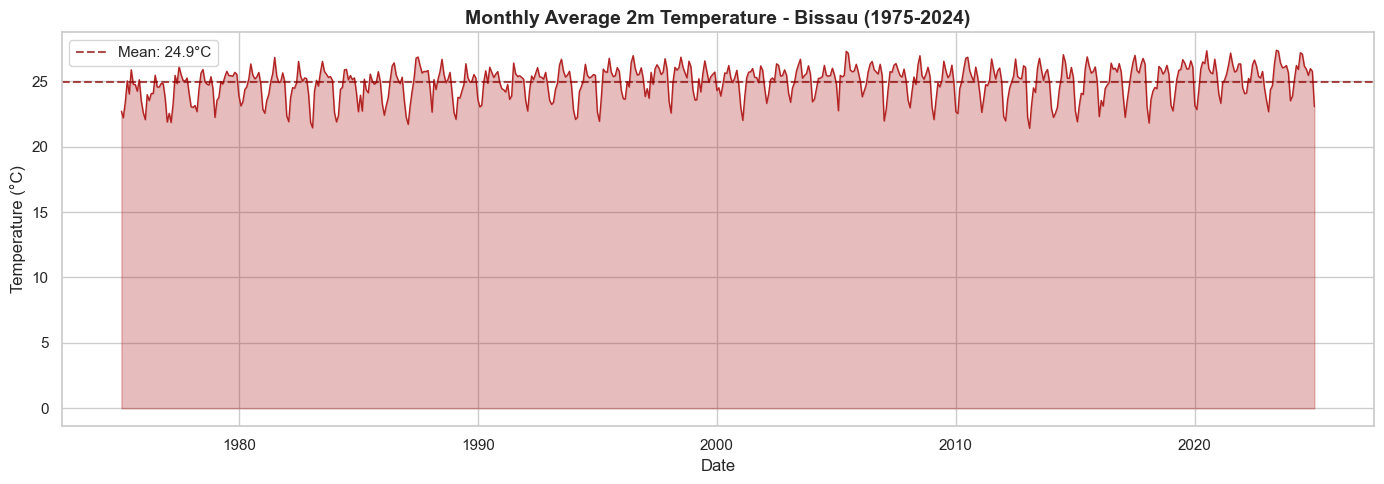

In [9]:
# -----------------------------
# Plot: 2m Temperature (t2m)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="t2m", ax=ax, color="firebrick", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["t2m"], alpha=0.3, color="firebrick")
ax.set_xlabel("Date")
ax.set_ylabel("Temperature (°C)")
ax.set_title(
    "Monthly Average 2m Temperature - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["t2m"].mean(),
    color="darkred",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['t2m'].mean():.1f}°C",
)
ax.legend()
plt.tight_layout()
plt.show()

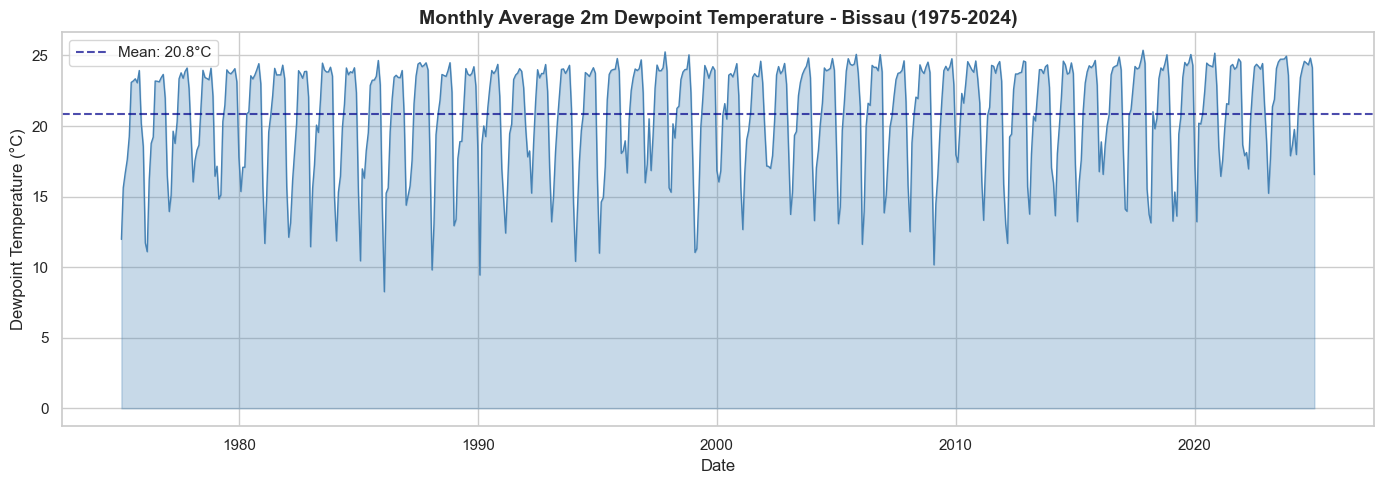

In [10]:
# -----------------------------
# Plot: 2m Dewpoint Temperature (d2m)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="d2m", ax=ax, color="steelblue", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["d2m"], alpha=0.3, color="steelblue")
ax.set_xlabel("Date")
ax.set_ylabel("Dewpoint Temperature (°C)")
ax.set_title(
    "Monthly Average 2m Dewpoint Temperature - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["d2m"].mean(),
    color="darkblue",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['d2m'].mean():.1f}°C",
)
ax.legend()
plt.tight_layout()
plt.show()

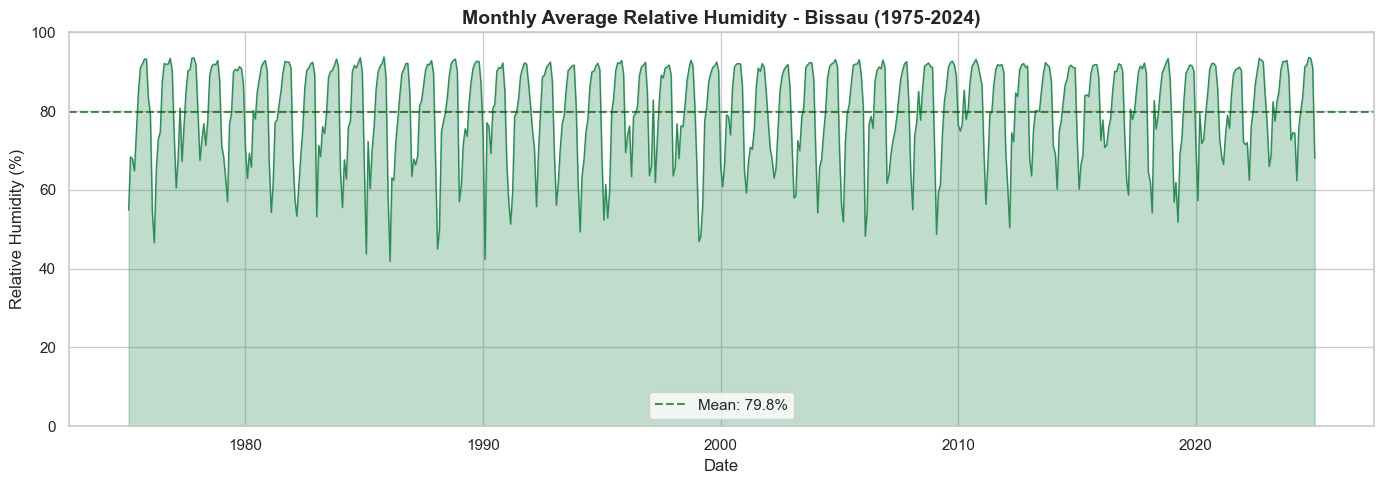

In [11]:
# -----------------------------
# Plot: Relative Humidity (rh) - Derived
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="rh", ax=ax, color="seagreen", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["rh"], alpha=0.3, color="seagreen")
ax.set_xlabel("Date")
ax.set_ylabel("Relative Humidity (%)")
ax.set_title(
    "Monthly Average Relative Humidity - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["rh"].mean(),
    color="darkgreen",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['rh'].mean():.1f}%",
)
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()

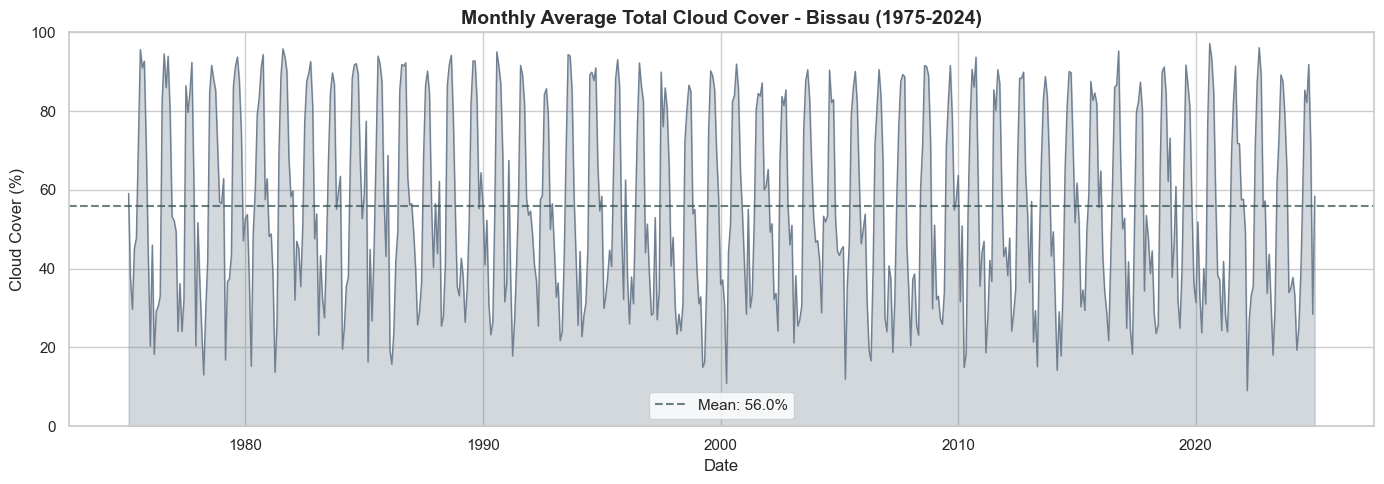

In [12]:
# -----------------------------
# Plot: Total Cloud Cover (tcc)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="tcc", ax=ax, color="slategray", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["tcc"], alpha=0.3, color="slategray")
ax.set_xlabel("Date")
ax.set_ylabel("Cloud Cover (%)")
ax.set_title(
    "Monthly Average Total Cloud Cover - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["tcc"].mean(),
    color="darkslategray",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['tcc'].mean():.1f}%",
)
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()

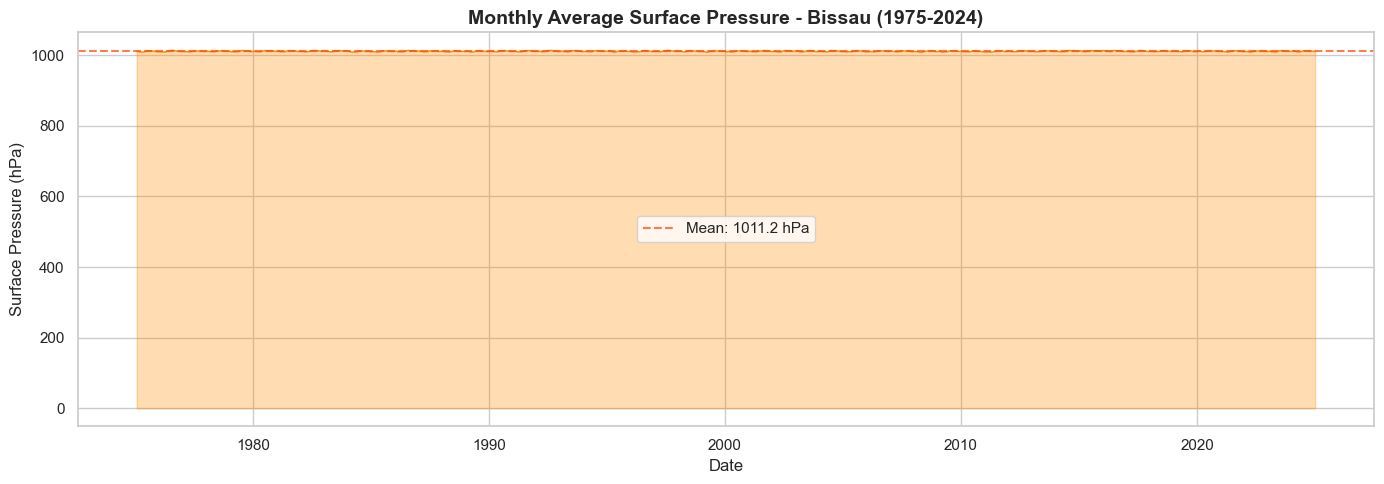

In [13]:
# -----------------------------
# Plot: Surface Pressure (sp)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="sp", ax=ax, color="darkorange", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["sp"], alpha=0.3, color="darkorange")
ax.set_xlabel("Date")
ax.set_ylabel("Surface Pressure (hPa)")
ax.set_title(
    "Monthly Average Surface Pressure - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["sp"].mean(),
    color="orangered",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['sp'].mean():.1f} hPa",
)
ax.legend()
plt.tight_layout()
plt.show()

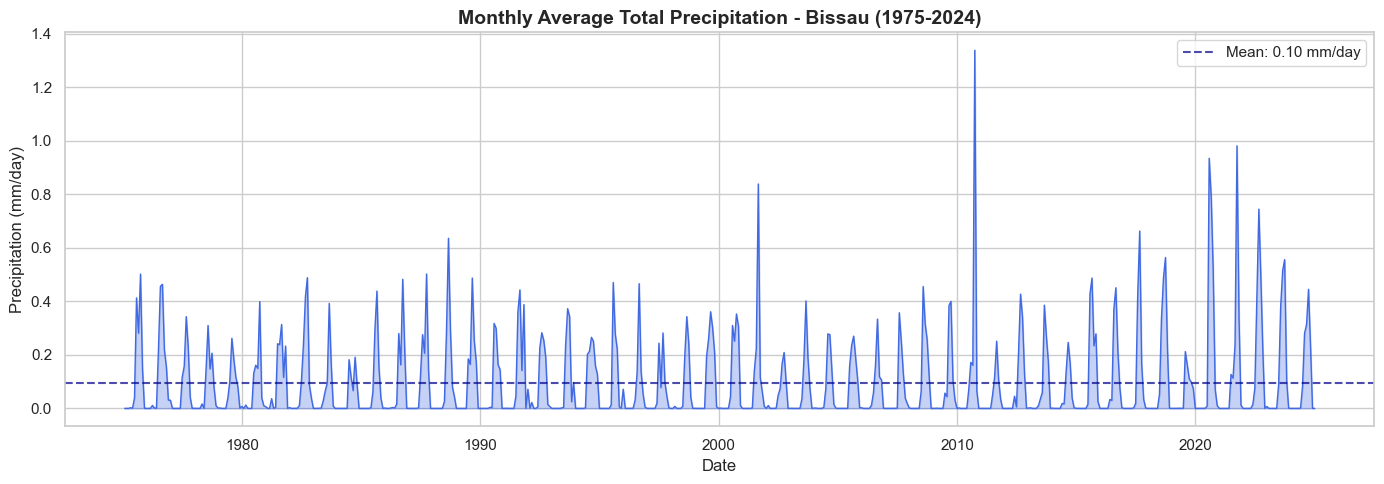

In [14]:
# -----------------------------
# Plot: Total Precipitation (tp)
# -----------------------------
fig, ax = plt.subplots(figsize=(14, 5))
sns.lineplot(
    data=df_monthly, x=df_monthly.index, y="tp", ax=ax, color="royalblue", linewidth=1
)
ax.fill_between(df_monthly.index, df_monthly["tp"], alpha=0.3, color="royalblue")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (mm/day)")
ax.set_title(
    "Monthly Average Total Precipitation - Bissau (1975-2024)",
    fontsize=14,
    fontweight="bold",
)
ax.axhline(
    df_monthly["tp"].mean(),
    color="darkblue",
    linestyle="--",
    alpha=0.7,
    label=f"Mean: {df_monthly['tp'].mean():.2f} mm/day",
)
ax.legend()
plt.tight_layout()
plt.show()

## Geographic Context

Map showing the location of the 5×5 grid over Guinea-Bissau.


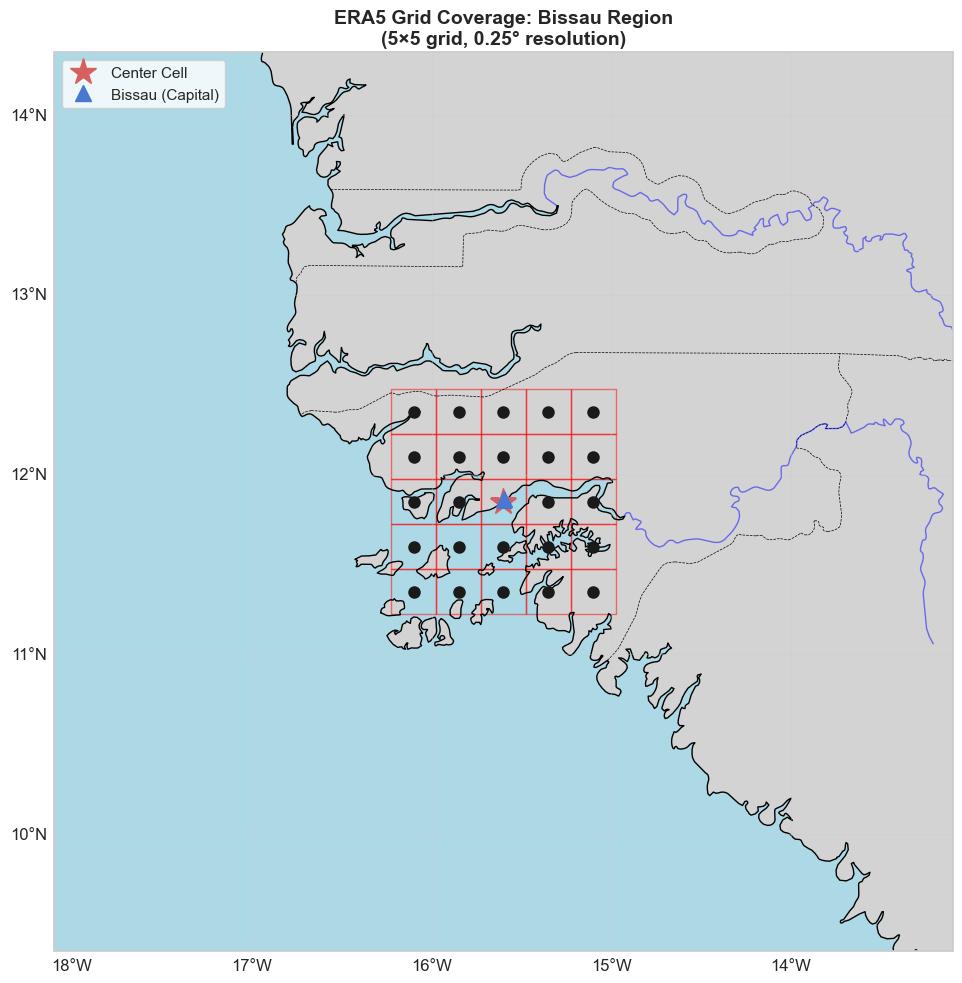


Center cell coordinates: 11.85°N, -15.60°E


In [15]:
# -----------------------------
# Geographic Map: Grid Location
# -----------------------------
fig = plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set extent around Guinea-Bissau (with some padding)
lat_min, lat_max = float(ds.latitude.min()), float(ds.latitude.max())
lon_min, lon_max = float(ds.longitude.min()), float(ds.longitude.max())
padding = 2.0
ax.set_extent(
    [lon_min - padding, lon_max + padding, lat_min - padding, lat_max + padding]
)

# Add map features
ax.add_feature(cfeature.LAND, facecolor="lightgray")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle="--", linewidth=0.5)
ax.add_feature(cfeature.RIVERS, edgecolor="blue", alpha=0.5)

# Plot the 5x5 grid cells
lats = ds.latitude.values
lons = ds.longitude.values

# Plot grid points
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        if i == CENTER_LAT_IDX and j == CENTER_LON_IDX:
            # Highlight center cell
            ax.plot(
                lon,
                lat,
                "r*",
                markersize=20,
                transform=ccrs.PlateCarree(),
                label=(
                    "Center Cell" if i == CENTER_LAT_IDX and j == CENTER_LON_IDX else ""
                ),
            )
        else:
            ax.plot(lon, lat, "ko", markersize=8, transform=ccrs.PlateCarree())

# Draw grid box
grid_resolution = 0.25  # ERA5 resolution
for lat in lats:
    for lon in lons:
        rect = plt.Rectangle(
            (lon - grid_resolution / 2, lat - grid_resolution / 2),
            grid_resolution,
            grid_resolution,
            fill=False,
            edgecolor="red",
            linewidth=1,
            alpha=0.5,
            transform=ccrs.PlateCarree(),
        )
        ax.add_patch(rect)

# Add Bissau city marker
ax.plot(
    -15.5975,
    11.8636,
    "b^",
    markersize=12,
    transform=ccrs.PlateCarree(),
    label="Bissau (Capital)",
)

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

ax.legend(loc="upper left")
ax.set_title(
    f"ERA5 Grid Coverage: Bissau Region\n({len(lats)}×{len(lons)} grid, 0.25° resolution)",
    fontsize=14,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

print(
    f"\nCenter cell coordinates: {float(ds.latitude[CENTER_LAT_IDX]):.2f}°N, {float(ds.longitude[CENTER_LON_IDX]):.2f}°E"
)

## Seasonal Patterns

Monthly climatology showing the typical seasonal cycle for each variable.


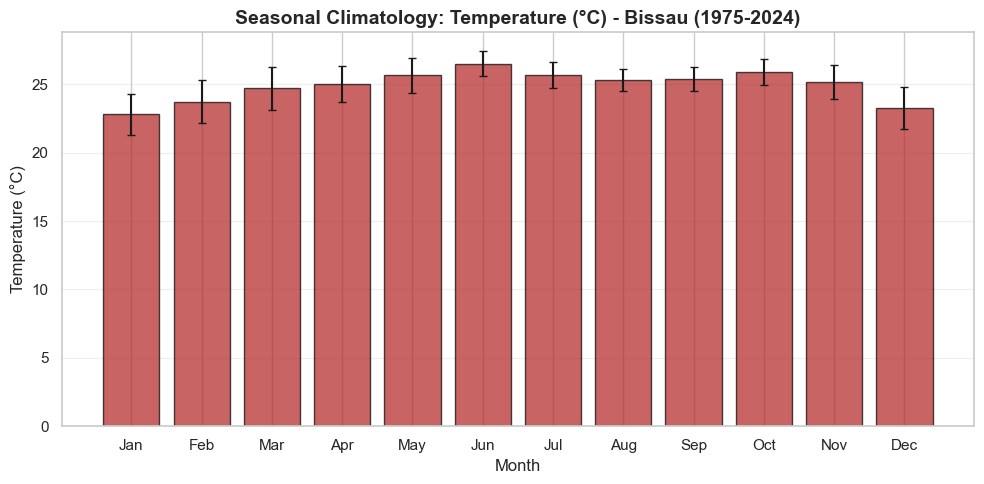

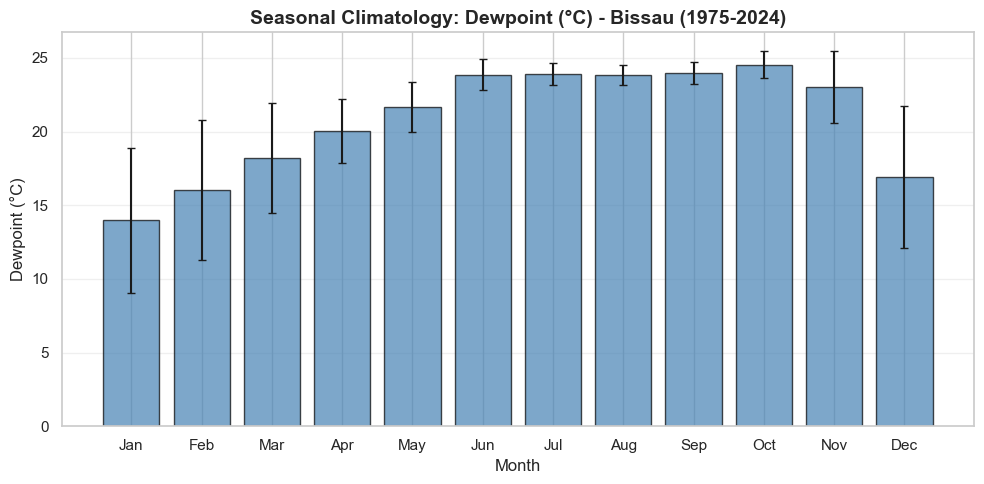

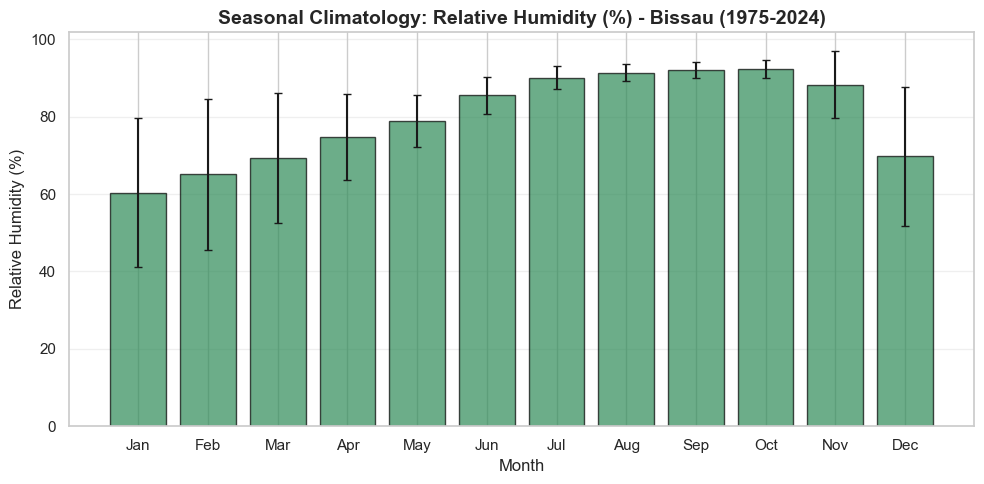

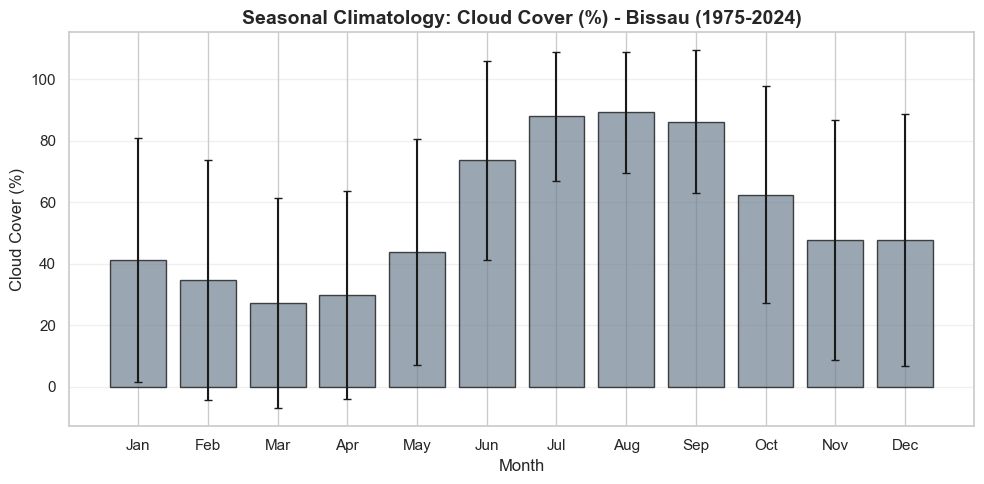

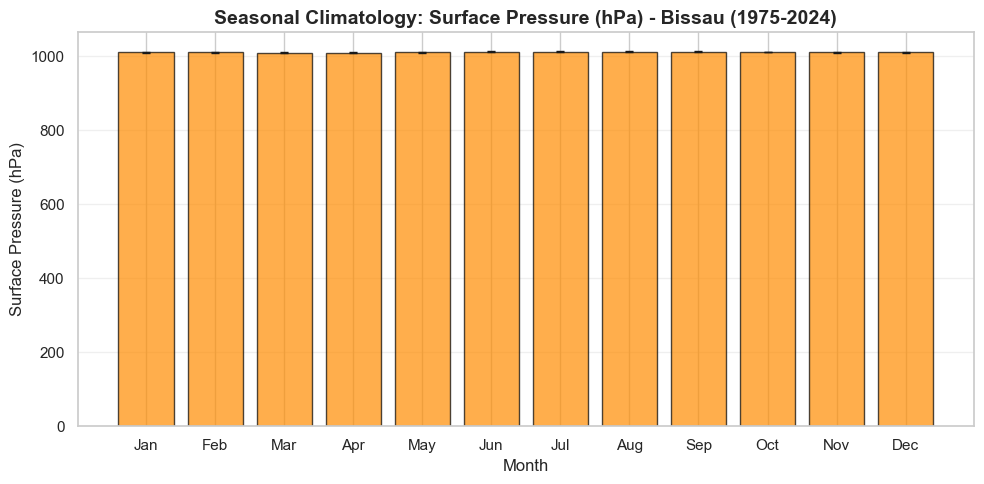

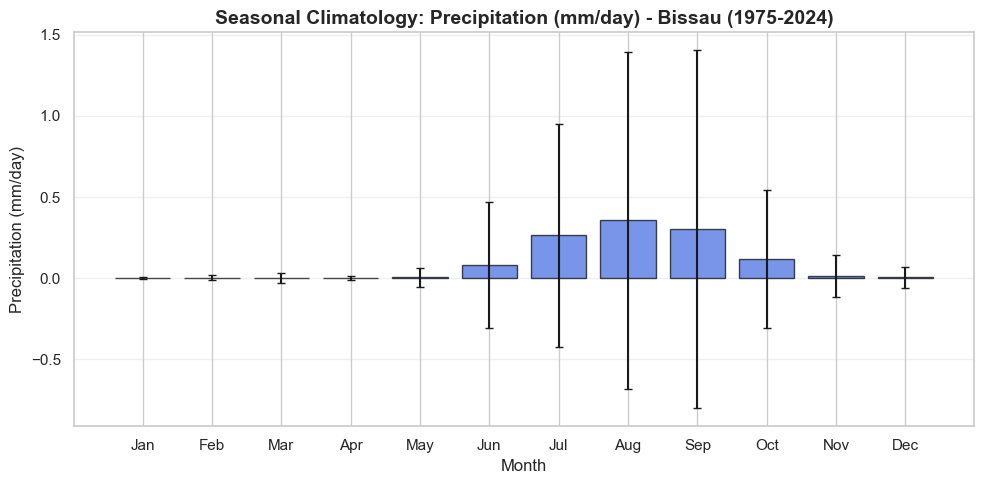

In [16]:
# -----------------------------
# Seasonal Climatology (Monthly Averages by Month)
# -----------------------------
df["month"] = df.index.month
monthly_clim = df.groupby("month").agg(["mean", "std"])

# Variable info for plotting
variables = {
    "t2m": ("Temperature (°C)", "firebrick"),
    "d2m": ("Dewpoint (°C)", "steelblue"),
    "rh": ("Relative Humidity (%)", "seagreen"),
    "tcc": ("Cloud Cover (%)", "slategray"),
    "sp": ("Surface Pressure (hPa)", "darkorange"),
    "tp": ("Precipitation (mm/day)", "royalblue"),
}

month_names = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]

for var, (ylabel, color) in variables.items():
    fig, ax = plt.subplots(figsize=(10, 5))

    means = monthly_clim[var]["mean"]
    stds = monthly_clim[var]["std"]

    ax.bar(
        range(1, 13),
        means,
        yerr=stds,
        color=color,
        alpha=0.7,
        capsize=3,
        edgecolor="black",
    )
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(month_names)
    ax.set_xlabel("Month")
    ax.set_ylabel(ylabel)
    ax.set_title(
        f"Seasonal Climatology: {ylabel} - Bissau (1975-2024)",
        fontsize=14,
        fontweight="bold",
    )
    ax.grid(axis="y", alpha=0.3)

    plt.tight_layout()
    plt.show()

In [17]:
# -----------------------------
# Summary Statistics Table
# -----------------------------
summary_data = {
    "Variable": [
        "Temperature",
        "Dewpoint",
        "Relative Humidity",
        "Cloud Cover",
        "Surface Pressure",
        "Precipitation",
    ],
    "Symbol": ["t2m", "d2m", "rh", "tcc", "sp", "tp"],
    "Unit": ["°C", "°C", "%", "%", "hPa", "mm/day"],
    "Mean": [
        df["t2m"].mean(),
        df["d2m"].mean(),
        df["rh"].mean(),
        df["tcc"].mean(),
        df["sp"].mean(),
        df["tp"].mean(),
    ],
    "Std": [
        df["t2m"].std(),
        df["d2m"].std(),
        df["rh"].std(),
        df["tcc"].std(),
        df["sp"].std(),
        df["tp"].std(),
    ],
    "Min": [
        df["t2m"].min(),
        df["d2m"].min(),
        df["rh"].min(),
        df["tcc"].min(),
        df["sp"].min(),
        df["tp"].min(),
    ],
    "Max": [
        df["t2m"].max(),
        df["d2m"].max(),
        df["rh"].max(),
        df["tcc"].max(),
        df["sp"].max(),
        df["tp"].max(),
    ],
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(2)

print("=" * 80)
print("DATA DISCOVERY SUMMARY - Bissau ERA5 Daily Data (1975-2024)")
print("=" * 80)
print(
    f"\nTime period: {time_values.min().strftime('%Y-%m-%d')} to {time_values.max().strftime('%Y-%m-%d')}"
)
print(f"Total observations: {len(df):,} days")
print(
    f"Center cell location: {float(ds.latitude[CENTER_LAT_IDX]):.2f}°N, {float(ds.longitude[CENTER_LON_IDX]):.2f}°E"
)
print("\n")
print(summary_df.to_string(index=False))

DATA DISCOVERY SUMMARY - Bissau ERA5 Daily Data (1975-2024)

Time period: 1975-01-01 to 2024-12-31
Total observations: 18,263 days
Center cell location: 11.85°N, -15.60°E


         Variable Symbol   Unit        Mean       Std         Min         Max
      Temperature    t2m     °C   24.930000  1.640000   18.620001   31.379999
         Dewpoint    d2m     °C   20.850000  4.560000    0.080000   27.670000
Relative Humidity     rh      %   79.889999 16.090000   21.219999   99.860001
      Cloud Cover    tcc      %   56.090000 40.240002    0.000000  100.000000
 Surface Pressure     sp    hPa 1011.190002  1.630000 1005.200012 1017.500000
    Precipitation     tp mm/day    0.100000  0.530000    0.000000   24.930000
